In [1]:
import sys
sys.path.append("../src")
from utils import *

In [2]:
adata_rc = sc.read(os.path.join(datadir, "rescue_cohort_anca_samples_processed.h5ad"))

In [9]:
adata_rc

AnnData object with n_obs × n_vars = 459 × 14771
    obs: 'in_tissue', 'array_row', 'array_col', 'Sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'n_genes', 'n_counts', 'Condition'
    var: 'gene_ids', 'feature_types', 'genome', 'mt', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'hvg', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    obsp: 'connectivities', 'distances'

In [5]:
adata_anca = sc.read(os.path.join(datadir, "anca_samples_annotated_v2.h5ad"))

In [7]:
geneset1 = adata_anca.var.loc[adata_anca.var["highly_variable"]].index.tolist()
geneset1 = [gene for gene in geneset1 if gene in adata_rc.var_names]

In [8]:
df = pd.DataFrame(index=adata_anca.var.index, columns=["mean", "stddev"])
adata_anca.var["mean"] = adata_anca.to_df().mean()
adata_anca.var["std"] = adata_anca.to_df().std()

In [9]:
import symphonypy as sp

In [10]:
sp.pp.harmony_integrate(adata_anca, key="Sample")

2023-11-09 13:29:38,222 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2023-11-09 13:29:41,214 - harmonypy - INFO - sklearn.KMeans initialization complete.


In [11]:
adata_rc.shape

(459, 14771)

In [12]:
tmp1 = adata_rc[:, geneset1]
sp.tl.map_embedding(tmp1, adata_anca)
sp.tl.per_cell_confidence(tmp1, adata_anca)

18 out of 1372 genes from the reference are missing in the query dataset or have zero std in the reference, their expressions in the query will be set to zero


In [13]:
sc.pp.neighbors(adata_anca, use_rep="X_pca_harmony")
sc.tl.umap(adata_anca)

In [14]:
sp.tl.transfer_labels_kNN(tmp1, adata_anca, "cluster_annot")

In [15]:
sp.tl.ingest(tmp1, adata_anca)

In [16]:
adata_rc.obsm["X_umap"] = tmp1.obsm["X_umap"].copy()

adata_rc.obs["cluster_annot"] = tmp1.obs["cluster_annot"].copy()

In [17]:
adata_combined = adata_rc.concatenate([adata_anca], uns_merge="unique")

/opt/conda/lib/python3.9/site-packages/anndata/_core/anndata.py:1755: FutureWarning: The AnnData.concatenate method is deprecated in favour of the anndata.concat function. Please use anndata.concat instead.

See the tutorial for concat at: https://anndata.readthedocs.io/en/latest/concatenation.html
  warnings.warn(


In [37]:
adata_rc.obs["cluster_annot"] = adata_rc.obs["cluster_annot"].astype("category")

In [38]:
import pickle
with open(os.path.join(datadir, "cluster_annot_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)
    
colors = []
for clst in adata_rc.obs["cluster_annot"].cat.categories:
    colors.append(colors_dict[clst])
adata_rc.uns["cluster_annot_colors"] = colors

In [39]:
sc.set_figure_params(dpi=100)
sns.set(style="ticks", font_scale=1.2)
plt.rcParams["font.family"] = ["Inter"]

In [40]:
tab = pd.DataFrame(adata_rc.obs["cluster_annot"].value_counts()).T
tab = tab.div(tab.sum(1),0)*100

col_order = ["PT", "PT/DCT", "DCT/CNT", "CNT/PC", "CNT/PC/IC", "PT/TAL", "LOH",
         "Interstitial", "Interstitial/Vessels", "Normal glomerular", "Inflamed glomerular", "Inflamed interstitial"]

In [41]:
import pickle
with open(os.path.join(datadir, "cluster_annot_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)

In [42]:
for col in col_order:
    if col not in tab.columns:
        tab[col] = 0

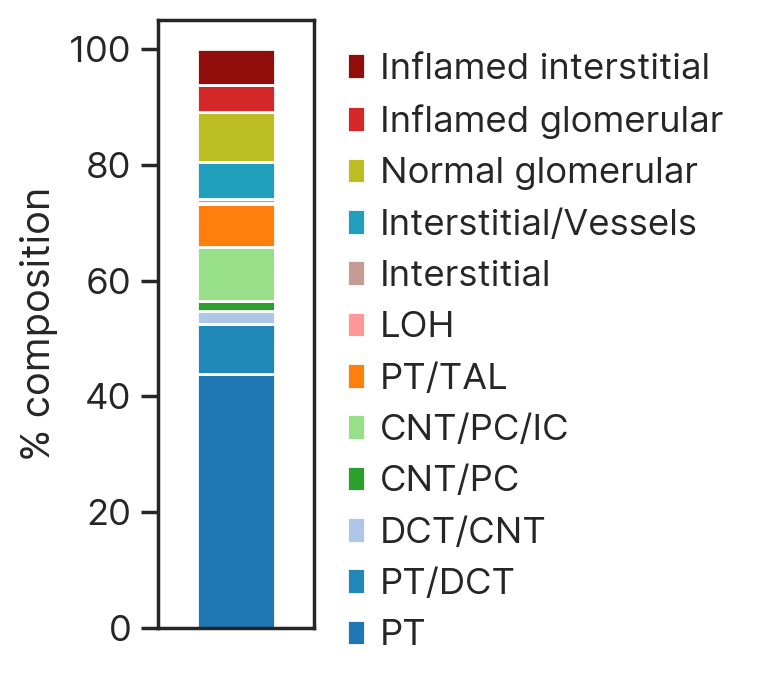

In [43]:
ax = tab[col_order].plot(kind="bar", stacked=True, figsize=(1,4), color=colors_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), frameon=False)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticks([],[])
ax.set_ylabel("% composition")

plt.savefig(os.path.join(figdir, "BARPLOT_rescue_cohort_coloredByCluster_annot.pdf"), bbox_inches="tight")

# merge

In [44]:
keep_clusters = ["Normal glomerular", "Inflamed glomerular", "Interstitial", "Interstitial/Vessels", "Inflamed interstitial"]
tubule_clusters = []
for cluster in adata_combined.obs.cluster_annot.unique():
    if cluster not in keep_clusters:
        tubule_clusters.append(cluster)
broad_mapping = dict(zip(tubule_clusters, ["Tubules"]*len(tubule_clusters)))

In [45]:
adata_rc.obs["cluster_annot_broad"] = adata_rc.obs["cluster_annot"].replace(broad_mapping)

In [46]:
tab = pd.DataFrame(adata_rc.obs["cluster_annot_broad"].value_counts()).T

tab = tab.div(tab.sum(1),0)*100

col_order = ["Tubules", "Interstitial", "Interstitial/Vessels", "Normal glomerular", "Inflamed glomerular", "Inflamed interstitial"]

In [47]:
with open(os.path.join(datadir, "cluster_annot_broad_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)

In [48]:
for col in col_order:
    if col not in tab.columns:
        tab[col] = 0

In [49]:
with open(os.path.join(datadir, "cluster_annot_broad_colors.pkl"), "rb") as f:
    colors_dict = pickle.load(f)
    
colors = []
for clst in adata_rc.obs["cluster_annot_broad"].cat.categories:
    colors.append(colors_dict[clst])
adata_rc.uns["cluster_annot_broad_colors"] = colors

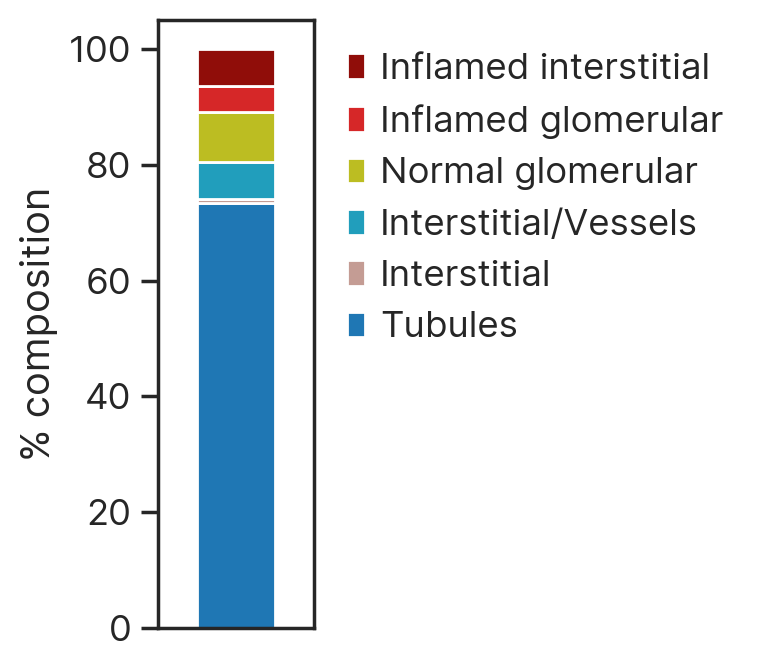

In [50]:
ax = tab[col_order].plot(kind="bar", stacked=True, figsize=(1,4), color=colors_dict)

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles[::-1], labels[::-1], bbox_to_anchor=(1,1), frameon=False)

ax.set_xlabel("")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.set_xticks([],[])

ax.set_ylabel("% composition")

plt.savefig(os.path.join(figdir, "BARPLOT_rescue_cohort_coloredByCluster_annot_broad.pdf"), bbox_inches="tight")

In [51]:
sc.pl.umap(adata_rc, color=["cluster_annot",  "cluster_annot_broad"], 
           wspace=0.5, title=["Cluster", "Cluster (merged)"], show=False, ncols=2)
plt.savefig(os.path.join(figdir, "UMAP_rescue_cohort_anca_samples_coloredByCluster_annot_Cluster_annot_broad.pdf"), 
            bbox_inches="tight")
plt.clf()

<Figure size 1200x400 with 0 Axes>

In [52]:
adata_combined.write(os.path.join(datadir, "rescue_cohort_anca_samples_clustered.h5ad"))

In [54]:
image_figdir = os.path.join(figdir, "cluster_on_images")
if not os.path.exists(image_figdir):
    os.mkdir(image_figdir)

In [ ]:
for sample in adata_rc.obs.Sample.unique():
    tmp = adata_rc[adata_rc.obs.Sample==sample]
    sc.pl.spatial(tmp, color=[None, "cluster_annot"], library_id=sample, title=[sample, "cluster"], alpha_img=0.7, s=10, show=False)
    plt.savefig(os.path.join(image_figdir, f"SPATIALSCATTER_{sample}_coloredByCluster_annot.pdf"), bbox_inches="tight")